In [ ]:
from pathlib import Path
import torch
import pandas as pd
from typing import List, Dict
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
from PIL import Image


from model_builder import LearnedFeatureFusionModel

from data_setup import SkinDataset
from utils import (
    load_model, predict_test_set, plot_curves_on_training_data, 
    plot_curves_on_training_validation_data, predict_and_visualize, evaluate_skin_tone
    )

import warnings

warnings.simplefilter("default")  

device = "cuda" if torch.cuda.is_available() else "cpu"

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




c:\Users\ACER NITRO\anaconda3\envs\cuda\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 1. Load the model

In [2]:
target_dir = "models"
model_name_mul = "mul_efficientnet_b5_N_Epochs=40_batch=8_lr=0.0001_melanoma.pth"
model_name_add = "add_efficientnet_b5_N_Epochs=40_batch=8_lr=0.0001_melanoma.pth"
model_name_concat = "concat_efficientnet_b5_N_Epochs=40_batch=8_lr=0.0001_melanoma.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mul_model = load_model(model_class=LearnedFeatureFusionModel, 
                          target_dir=target_dir, 
                          model_name=model_name_mul, 
                          device=device, 
                          num_classes=2,
                          fusion_operation="mul")

add_model = load_model(model_class=LearnedFeatureFusionModel, 
                          target_dir=target_dir, 
                          model_name=model_name_add, 
                          device=device, 
                          num_classes=2,
                          fusion_operation="add")

concat_model = load_model(model_class=LearnedFeatureFusionModel, 
                          target_dir=target_dir, 
                          model_name=model_name_concat, 
                          device=device, 
                          num_classes=2,
                          fusion_operation="concat")


c:\Users\ACER NITRO\Desktop\SID\Skin Cancer Classification\Fusion Model melanoma\utils.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torc

Loaded model from: models\mul_efficientnet_b5_N_Epochs=40_batch=8_lr=0.0001_melanoma.pth with fusion type: mul
Loaded model from: models\add_efficientnet_b5_N_Epochs=40_batch=8_lr=0.0001_melanoma.pth with fusion type: add
Loaded model from: models\concat_efficientnet_b5_N_Epochs=40_batch=8_lr=0.0001_melanoma.pth with fusion type: concat


## Load the data

In [3]:
images_path = Path("data/")
test_images_path = r'data\test'


In [4]:
test_metadata = pd.read_csv("data/test_metadata.csv")
test_metadata.head()


,DDI_ID,DDI_file,malignant,DDI_path,skin_tone_12,skin_tone_34,skin_tone_56,Disease_Group_Non_melanoma,Disease_Group_melanoma
0,300,000300.png,1,data\test\malignant\000300.png,1,0,0,1,0
1,40,000040.png,1,data\test\malignant\000040.png,1,0,0,1,0
2,422,000422.png,0,data\test\benign\000422.png,1,0,0,1,0
3,289,000289.png,1,data\test\malignant\000289.png,1,0,0,1,0
4,258,000258.png,0,data\test\benign\000258.png,1,0,0,1,0


In [5]:
weights = torchvision.models.EfficientNet_B5_Weights.DEFAULT
data_transform = weights.transforms()
data_transform


ImageClassification(
    crop_size=[456]
    resize_size=[456]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## Make prediction

### We'll begin by make prediction on two images

True Label: 0 | Predicted Class: 0


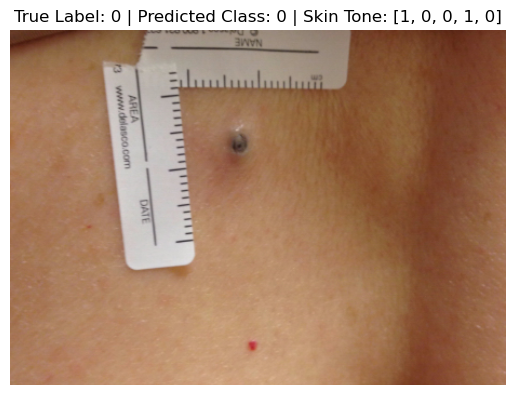

True Label: 1 | Predicted Class: 1


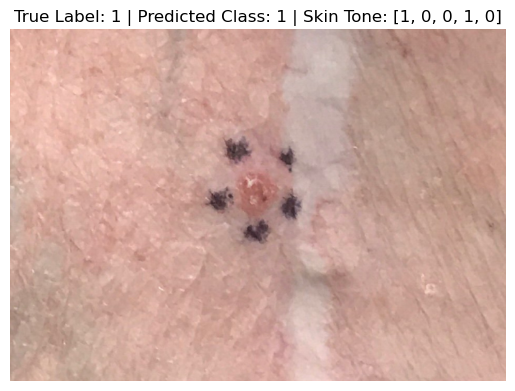

In [6]:
predict_and_visualize(test_metadata, index=12, data_transform=data_transform, loaded_model=mul_model, device=device)
predict_and_visualize(test_metadata, index=0, data_transform=data_transform, loaded_model=mul_model, device=device)


### Now we'll make prediction on all the images, then we'll make prediction on all the skin tone types

In [7]:
skin_tone_12_df = test_metadata[test_metadata["skin_tone_12"] == 1]
skin_tone_34_df = test_metadata[test_metadata["skin_tone_34"] == 1]
skin_tone_56_df = test_metadata[test_metadata["skin_tone_56"] == 1]


In [10]:
df = pd.DataFrame(columns=["tta_augmenation", "model_name", "auc", "auc_12", "auc_34", "auc_56", "accuracy", "accuracy_12", "accuracy_34", "accuracy_56"])


## Now we'll Use the Time-Test Augmentation Technique

In [12]:
true_labels_tta, predicted_classes_tta, metrics_tta = evaluate_skin_tone(loaded_model=mul_model, test_metadata=test_metadata, device = device)
true_labels_tta_12, predicted_classes_tta_12, metrics_tta_12 = evaluate_skin_tone(loaded_model=mul_model, test_metadata=test_metadata, device = device, skin_tone_column = "skin_tone_12")
true_labels_tta_34, predicted_classes_tta_34, metrics_tta_34 = evaluate_skin_tone(loaded_model=mul_model, test_metadata=test_metadata, device = device, skin_tone_column = "skin_tone_34")
true_labels_tta_56, predicted_classes_tta_56, metrics_tta_56 = evaluate_skin_tone(loaded_model=mul_model, test_metadata=test_metadata, device = device, skin_tone_column = "skin_tone_56")
test_metadata['mul_pred'] = predicted_classes_tta


df.loc[0] = [
    1,
    "mul_efficientnet_b5",
    metrics_tta['auc'], metrics_tta_12['auc'], metrics_tta_34['auc'], metrics_tta_56['auc'],
    metrics_tta['accuracy'], metrics_tta_12['accuracy'], metrics_tta_34['accuracy'], metrics_tta_56['accuracy']
]


In [13]:
df


,tta_augmenation,model_name,auc,auc_12,auc_34,auc_56,accuracy,accuracy_12,accuracy_34,accuracy_56
0,1,mul_efficientnet_b5,0.858667,0.8,0.875,0.941176,0.846154,0.818182,0.863636,0.904762


In [15]:
true_labels_tta, predicted_classes_tta, metrics_tta = evaluate_skin_tone(loaded_model=add_model, test_metadata=test_metadata, device = device)
true_labels_tta_12, predicted_classes_tta_12, metrics_tta_12 = evaluate_skin_tone(loaded_model=add_model, test_metadata=test_metadata, device = device, skin_tone_column = "skin_tone_12")
true_labels_tta_34, predicted_classes_tta_34, metrics_tta_34 = evaluate_skin_tone(loaded_model=add_model, test_metadata=test_metadata, device = device, skin_tone_column = "skin_tone_34")
true_labels_tta_56, predicted_classes_tta_56, metrics_tta_56 = evaluate_skin_tone(loaded_model=add_model, test_metadata=test_metadata, device = device, skin_tone_column = "skin_tone_56")

test_metadata['add_pred'] = predicted_classes_tta

df.loc[1] = [
    1,
    "add_efficientnet_b5",
    metrics_tta['auc'], metrics_tta_12['auc'], metrics_tta_34['auc'], metrics_tta_56['auc'],
    metrics_tta['accuracy'], metrics_tta_12['accuracy'], metrics_tta_34['accuracy'], metrics_tta_56['accuracy']
]


In [17]:
true_labels_tta, predicted_classes_tta, metrics_tta = evaluate_skin_tone(loaded_model=concat_model, test_metadata=test_metadata, device = device)
true_labels_tta_12, predicted_classes_tta_12, metrics_tta_12 = evaluate_skin_tone(loaded_model=concat_model, test_metadata=test_metadata, device = device, skin_tone_column = "skin_tone_12")
true_labels_tta_34, predicted_classes_tta_34, metrics_tta_34 = evaluate_skin_tone(loaded_model=concat_model, test_metadata=test_metadata, device = device, skin_tone_column = "skin_tone_34")
true_labels_tta_56, predicted_classes_tta_56, metrics_tta_56 = evaluate_skin_tone(loaded_model=concat_model, test_metadata=test_metadata, device = device, skin_tone_column = "skin_tone_56")

test_metadata['concat_pred'] = predicted_classes_tta

df.loc[2] = [
    1,
    "concat_efficientnet_b5",
    metrics_tta['auc'], metrics_tta_12['auc'], metrics_tta_34['auc'], metrics_tta_56['auc'],
    metrics_tta['accuracy'], metrics_tta_12['accuracy'], metrics_tta_34['accuracy'], metrics_tta_56['accuracy']
]


In [19]:
df.sort_values(by="auc", ascending=False) 


,tta_augmenation,model_name,auc,auc_12,auc_34,auc_56,accuracy,accuracy_12,accuracy_34,accuracy_56
1,1,add_efficientnet_b5,0.916000,0.894118,0.927083,0.970588,0.907692,0.909091,0.863636,0.952381
0,1,mul_efficientnet_b5,0.858667,0.800000,0.875000,0.941176,0.846154,0.818182,0.863636,0.904762
2,1,concat_efficientnet_b5,0.834667,0.847059,0.927083,0.764706,0.846154,0.863636,0.863636,0.809524


In [ ]:
df.sort_values(by="auc", ascending=False) 


,tta_augmenation,model_name,auc,auc_12,auc_34,auc_56,accuracy,accuracy_12,accuracy_34,accuracy_56
1,1,add_efficientnet_b5,0.916000,0.894118,0.927083,0.970588,0.907692,0.909091,0.863636,0.952381
0,1,mul_efficientnet_b5,0.858667,0.800000,0.875000,0.941176,0.846154,0.818182,0.863636,0.904762
2,1,concat_efficientnet_b5,0.834667,0.847059,0.927083,0.764706,0.846154,0.863636,0.863636,0.809524


In [20]:
indexes = df.index
Gap = []
for index in indexes:
    auc_12, auc_34, auc_56 = df.loc[index, "auc_12"], df.loc[index, "auc_34"], df.loc[index, "auc_56"]
    AUC_max,  AUC_min = np.max([auc_12, auc_34, auc_56]), np.min([auc_12, auc_34, auc_56])
    gap = AUC_max - AUC_min
    Gap.append(gap)
df["Gap"] = Gap

df.sort_values(by="Gap", ascending=True) 


,tta_augmenation,model_name,auc,auc_12,auc_34,auc_56,accuracy,accuracy_12,accuracy_34,accuracy_56,Gap
1,1,add_efficientnet_b5,0.916000,0.894118,0.927083,0.970588,0.907692,0.909091,0.863636,0.952381,0.076471
0,1,mul_efficientnet_b5,0.858667,0.800000,0.875000,0.941176,0.846154,0.818182,0.863636,0.904762,0.141176
2,1,concat_efficientnet_b5,0.834667,0.847059,0.927083,0.764706,0.846154,0.863636,0.863636,0.809524,0.162377
